# Quantum-Classical Hybrid Autoencoder for Medical Image Classification

This notebook implements a hybrid quantum-classical model for chest X-ray classification.

## Installation (Run if packages missing)

In [30]:
# Uncomment and run if you need to install packages
# %pip install torch torchvision numpy pennylane medmnist

## Imports

In [31]:
import numpy as np
import torch
import torch.nn as nn
import pennylane as qml
from pennylane.qnn import TorchLayer
import matplotlib.pyplot as plt

print("All imports successful!")
print(f"PyTorch version: {torch.__version__}")
print(f"PennyLane version: {qml.__version__}")

All imports successful!
PyTorch version: 2.9.0+cu130
PennyLane version: 0.43.0


## Settings

In [32]:
n_qubits = 6                 # set desired number of qubits
n_layers = 5                 # set desired number of quantum layers
latent_dim = 2**n_qubits     # latent dimension = 2^n_qubits
img_size = 224               # set desired image size (28, 64, 128, 224)
batch_size = 64
n_epochs = 100
n_workers = 4

print(f"Configuration:")
print(f"  Qubits: {n_qubits}")
print(f"  Quantum layers: {n_layers}")
print(f"  Latent dimension: {latent_dim}")
print(f"  Image size: {img_size}x{img_size}")
print(f"  Batch size: {batch_size}")
print(f"  Epochs: {n_epochs}")

Configuration:
  Qubits: 6
  Quantum layers: 5
  Latent dimension: 64
  Image size: 224x224
  Batch size: 64
  Epochs: 100


## Load Data from preprocess.py

We import the data loaders from our preprocess.py file to ensure consistency.

In [33]:
# Import data loaders from preprocess.py
from preprocess import train_dataset, test_dataset

print(f"Data loaded successfully!")
print(f"Training samples: {len(train_dataset)}")
print(f"Test samples: {len(test_dataset)}")

Data loaded successfully!
Training samples: 78468
Test samples: 22433


Filter Out Double-Labels

In [44]:
from torch.utils.data import Subset, DataLoader

# Filter training set
train_single_label_indices = []
for i in range(len(train_dataset)):
    _, label = train_dataset[i]
    if label.sum() == 1:  # Only one condition present
        train_single_label_indices.append(i)

train_dataset = Subset(train_dataset, train_single_label_indices)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True, num_workers=n_workers, pin_memory=True, persistent_workers=True)

# Filter test set
test_single_label_indices = []
for i in range(len(test_dataset)):
    _, label = test_dataset[i]
    if label.sum() == 1:
        test_single_label_indices.append(i)

test_dataset = Subset(test_dataset, test_single_label_indices)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, drop_last=False, num_workers=n_workers, pin_memory=True, persistent_workers=True)

print(f"Filtered Training: {len(train_dataset)} single-label images ({len(train_loader)} batches)")
print(f"Filtered Test: {len(test_dataset)} single-label images ({len(test_loader)} batches)")


Filtered Training: 21602 single-label images (337 batches)
Filtered Test: 6259 single-label images (98 batches)


## Classical Encoder

In [35]:
class Encoder(nn.Module):
    def __init__(self, latent_dim=64, img_size=224):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 128, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Linear(128, latent_dim)
        )
        
    def forward(self, x): return self.encoder(x)

## Quantum Circuit

In [46]:
import numpy as np

# ---- quantum device ----
dev = qml.device("lightning.qubit", wires=n_qubits)
#dev = qml.device("default.qubit", wires=n_qubits)

@qml.qnode(dev, interface="torch", diff_method="parameter-shift")
def qnode(inputs, weights):
    qml.AmplitudeEmbedding(inputs, wires=range(n_qubits), normalize=True, pad_with=0.0)
    qml.StronglyEntanglingLayers(weights, wires=range(n_qubits))
    return [qml.expval(qml.PauliZ(i)) for i in range(n_qubits)]

class QuantumHead(nn.Module):
    def __init__(self, n_layers, n_qubits, n_classes, latent_dim):
        super().__init__()
        self.n_qubits = n_qubits
        self.encoder_fc = nn.Linear(latent_dim, 2**n_qubits)
        nn.init.xavier_uniform_(self.encoder_fc.weight, gain=0.01)
        nn.init.zeros_(self.encoder_fc.bias)
        self.q_weights = nn.Parameter(torch.randn(n_layers, n_qubits, 3) * 0.001)
        self.readout = nn.Linear(n_qubits, n_classes)

    def _prepare_quantum_input(self, h):
        z = self.encoder_fc(h)
        z = torch.nan_to_num(torch.clamp(z, -5, 5))
        norm = torch.sqrt(torch.sum(z**2, dim=1, keepdim=True) + 1e-10)
        if (norm.squeeze() < 1e-6).any():
            uniform = torch.ones(2**self.n_qubits, device=z.device) / np.sqrt(2**self.n_qubits)
            z[norm.squeeze() < 1e-6] = uniform
            norm = torch.sqrt(torch.sum(z**2, dim=1, keepdim=True) + 1e-10)
        return z / norm
    
    def forward(self, h):
        device = h.device
        z_norm = self._prepare_quantum_input(h).cpu()
        q_w_cpu = self.q_weights.cpu()
        results = []
        for i in range(h.shape[0]):
            try:
                expvals = qnode_single(z_norm[i].detach(), q_w_cpu)
                results.append(torch.stack(expvals).float())
            except:
                results.append(torch.zeros(self.n_qubits))
        return self.readout(torch.stack(results).to(device))

print(f"Quantum device initialized: {dev}")

Quantum device initialized: <lightning.qubit device (wires=6) at 0x168e50b82b0>


## Hybrid Quantum-Classical Model

In [37]:
class HybridQML(nn.Module):
    def __init__(self, img_size, latent_dim, n_classes=14):
        super().__init__()
        self.enc = Encoder(latent_dim, img_size)
        self.qhead = QuantumHead(n_layers, n_qubits, n_classes, latent_dim)
    def forward(self, x, return_recon=False):
        return self.qhead(self.enc(x))

## Training Setup

In [47]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#device = torch.device("cpu")
print(f"Using device: {device}")

model = HybridQML(img_size=img_size, latent_dim=latent_dim, n_classes=14).to(device)
optimizer = torch.optim.AdamW(
    model.parameters(), 
    lr=5e-5,
    weight_decay=1e-5,
    eps=1e-7
)
criterion = nn.BCEWithLogitsLoss()

print(f"Model initialized: {sum(p.numel() for p in model.parameters()):,} parameters\n")

Using device: cuda
Model initialized: 105,276 parameters



In [39]:
import time

def train_one_epoch(epoch):
    model.train()
    total, n = 0.0, 0
    start_time = time.time()

    print(f"\n{'='*60}")
    print(f"EPOCH {epoch}/{n_epochs}")
    print(f"{'='*60}")
    
    for i, (imgs, labels) in enumerate(train_loader):
        imgs, labels = imgs.to(device), labels.float().to(device)
        logits = model(imgs, True)
        loss = criterion(logits, labels)
        optimizer.zero_grad(set_to_none=True)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        total += loss.item() * imgs.size(0)
        n += imgs.size(0)
        
        if i % max(1, len(train_loader) // 4) == 0:
            elapsed = time.time() - start_time
            progress = (i + 1) / len(train_loader) * 100
            print(f"  [{progress:5.1f}%] Batch {i:3d}/{len(train_loader)} | Loss: {total/n:.4f} | Time: {elapsed:.1f}s")
            
    epoch_time = time.time() - start_time
    avg_loss = total / n
    print(f"\nEpoch {epoch} complete in {epoch_time:.1f}s | Train Loss: {avg_loss:.4f}")
    return avg_loss, epoch_time

@torch.no_grad()
def evaluate():
    model.eval()
    total, n = 0.0, 0
    for imgs, labels in test_loader:
        imgs, labels = imgs.to(device), labels.float().to(device)
        loss = criterion(model(imgs), labels)
        total += loss.item() * imgs.size(0)
        n += imgs.size(0)
    return total / n


## Run Training

In [48]:
print(f"Training for {n_epochs} epochs...\n")

# Track results
train_losses = []
test_losses = []
epoch_times = []
best_test_loss = float('inf')
best_epoch = 0

total_start = time.time()

for epoch in range(1, n_epochs + 1):
    train_loss, epoch_time = train_one_epoch(epoch)
    test_loss = evaluate()
    
    train_losses.append(train_loss)
    test_losses.append(test_loss)
    epoch_times.append(epoch_time)
    
    # Track best model
    if test_loss < best_test_loss:
        best_test_loss = test_loss
        best_epoch = epoch
        # Save best model
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'train_loss': train_loss,
            'test_loss': test_loss,
        }, 'best_model.pt')
        #print(f"New best model saved! (Test Loss: {test_loss:.4f})")
    
    print(f"Test Loss: {test_loss:.4f} | Best: {best_test_loss:.4f} (Epoch {best_epoch})")

total_time = time.time() - total_start
print(f"\nTraining complete in {total_time/60:.2f} minutes.")

Training for 100 epochs...


EPOCH 1/100
  [  0.3%] Batch   0/337 | Loss: 0.7418 | Time: 0.2s
  [ 25.2%] Batch  84/337 | Loss: 0.7370 | Time: 1.2s
  [ 50.1%] Batch 168/337 | Loss: 0.7362 | Time: 2.0s
  [ 75.1%] Batch 252/337 | Loss: 0.7353 | Time: 2.7s
  [100.0%] Batch 336/337 | Loss: 0.7343 | Time: 3.5s

Epoch 1 complete in 3.5s | Train Loss: 0.7343
Test Loss: 0.7303 | Best: 0.7303 (Epoch 1)

EPOCH 2/100
  [  0.3%] Batch   0/337 | Loss: 0.7327 | Time: 0.1s
  [ 25.2%] Batch  84/337 | Loss: 0.7296 | Time: 0.8s
  [ 50.1%] Batch 168/337 | Loss: 0.7286 | Time: 1.6s
  [ 75.1%] Batch 252/337 | Loss: 0.7276 | Time: 2.4s
  [100.0%] Batch 336/337 | Loss: 0.7267 | Time: 3.2s

Epoch 2 complete in 3.2s | Train Loss: 0.7267
Test Loss: 0.7228 | Best: 0.7228 (Epoch 2)

EPOCH 3/100
  [  0.3%] Batch   0/337 | Loss: 0.7234 | Time: 0.1s
  [ 25.2%] Batch  84/337 | Loss: 0.7219 | Time: 0.8s
  [ 50.1%] Batch 168/337 | Loss: 0.7211 | Time: 1.7s
  [ 75.1%] Batch 252/337 | Loss: 0.7202 | Time: 2.5s
  [100.0%] 

Results Summary

In [49]:
print(f"Training Statistics:")
print(f"  Total epochs: {n_epochs}")
print(f"  Total time: {total_time/60:.1f} minutes ({total_time:.1f} seconds)")
print(f"  Average time per epoch: {np.mean(epoch_times):.1f} seconds")
print(f"\nLoss Progression:")
print(f"  Initial train loss: {train_losses[0]:.4f}")
print(f"  Final train loss: {train_losses[-1]:.4f}")
print(f"  Improvement: {(train_losses[0] - train_losses[-1])/train_losses[0]*100:.1f}%")
print(f"\nInitial test loss: {test_losses[0]:.4f}")
print(f"  Final test loss: {test_losses[-1]:.4f}")
print(f"  Best test loss: {best_test_loss:.4f} (Epoch {best_epoch})")
print(f"  Improvement: {(test_losses[0] - best_test_loss)/test_losses[0]*100:.1f}%")
print(f"\nModel saved as: best_model.pt")
print(f"\nPerformance:")
print(f"  Training time: {total_time/60:.1f} minutes")

Training Statistics:
  Total epochs: 100
  Total time: 10.2 minutes (609.7 seconds)
  Average time per epoch: 4.7 seconds

Loss Progression:
  Initial train loss: 0.7343
  Final train loss: 0.3024
  Improvement: 58.8%

Initial test loss: 0.7303
  Final test loss: 0.3015
  Best test loss: 0.3015 (Epoch 100)
  Improvement: 58.7%

Model saved as: best_model.pt

Performance:
  Training time: 10.2 minutes



Training curves saved as: training_results.png


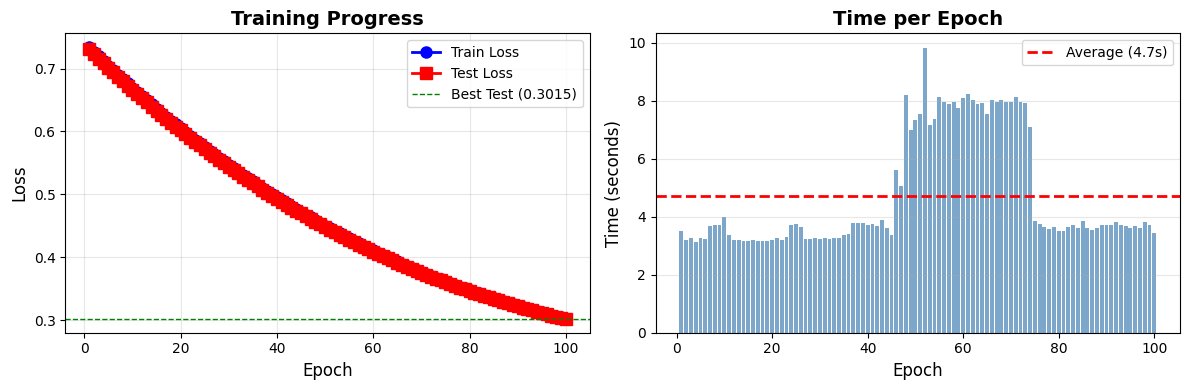

In [50]:
# Plot training curves
plt.figure(figsize=(12, 4))

# Loss plot
plt.subplot(1, 2, 1)
epochs_range = range(1, n_epochs + 1)
plt.plot(epochs_range, train_losses, 'b-o', label='Train Loss', linewidth=2, markersize=8)
plt.plot(epochs_range, test_losses, 'r-s', label='Test Loss', linewidth=2, markersize=8)
plt.axhline(y=best_test_loss, color='g', linestyle='--', label=f'Best Test ({best_test_loss:.4f})', linewidth=1)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.title('Training Progress', fontsize=14, fontweight='bold')
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)

# Time plot
plt.subplot(1, 2, 2)
plt.bar(epochs_range, epoch_times, color='steelblue', alpha=0.7)
plt.axhline(y=np.mean(epoch_times), color='r', linestyle='--', label=f'Average ({np.mean(epoch_times):.1f}s)', linewidth=2)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Time (seconds)', fontsize=12)
plt.title('Time per Epoch', fontsize=14, fontweight='bold')
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('training_results.png', dpi=150, bbox_inches='tight')
print("\nTraining curves saved as: training_results.png")
plt.show()

Save Final Model

In [51]:
# Save final model and training history
torch.save({
    'n_epochs': n_epochs,
    'final_epoch': n_epochs,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'train_losses': train_losses,
    'test_losses': test_losses,
    'epoch_times': epoch_times,
    'best_test_loss': best_test_loss,
    'best_epoch': best_epoch,
    'config': {
        'n_qubits': n_qubits,
        'n_layers': n_layers,
        'latent_dim': latent_dim,
        'img_size': img_size,
        'batch_size': batch_size,
    }
}, 'final_model_complete.pt')

print("\nComplete training history saved as: final_model_complete.pt")
print("\nThis includes:")
print("  - Final model weights")
print("  - All loss curves")
print("  - Training times")
print("  - Configuration")


Complete training history saved as: final_model_complete.pt

This includes:
  - Final model weights
  - All loss curves
  - Training times
  - Configuration
